# Arizona Coyotes - Default Retention Model
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 14, 2022

## Hypothesis
This notebook contains the data pre-processing, model training and evaluation of the Coyotes retention model with the default StellarAlgo features. We think that the distToVenue feature could be a significant indicator for Full Season ticket buyers.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

NameError: name '_all_models_internal' is not defined

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [14]:
lkupclientid = 55 # coyotes
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCoyotes].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(17441, 54)

### Let's specify the default SA features for our model:

In [15]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (11598, 9)
Unseen Data For Predictions: (2047, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [16]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's compare all models to evaluate performance. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [17]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    exclude=["lda","qda"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7199,0.7655,0.5733,0.6702,0.6176,0.3989,0.4021,0.5580
gbc,Gradient Boosting Classifier,0.7153,0.7644,0.5818,0.6579,0.6171,0.3919,0.3941,0.0950
xgboost,Extreme Gradient Boosting,0.7131,0.7592,0.5690,0.6583,0.6100,0.3851,0.3879,0.3330
ada,Ada Boost Classifier,0.7047,0.7487,0.5723,0.6415,0.6048,0.3703,0.3720,0.0390
rf,Random Forest Classifier,0.6898,0.7381,0.5595,0.6187,0.5873,0.3399,0.3412,0.2030
knn,K Neighbors Classifier,0.6667,0.6862,0.5441,0.5844,0.5633,0.2943,0.2950,0.0330
et,Extra Trees Classifier,0.6641,0.7039,0.5461,0.5798,0.5622,0.2902,0.2907,0.1820
lr,Logistic Regression,0.6461,0.6645,0.3637,0.5830,0.4476,0.2075,0.2201,0.1280
ridge,Ridge Classifier,0.6384,0.0000,0.3591,0.5664,0.4393,0.1919,0.2028,0.0060
nb,Naive Bayes,0.6367,0.6590,0.3771,0.5595,0.4462,0.1935,0.2027,0.0070


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.54418e-10): result may not be accurate.
  overwrite_a=True).T


[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5751 val_loss=0.0000 scale=2.0000 norm=3.8179
[iter 200] loss=0.5618 val_loss=0.0000 scale=2.0000 norm=3.8566
[iter 300] loss=0.5583 val_loss=0.0000 scale=2.0000 norm=3.8670
[iter 400] loss=0.5560 val_loss=0.0000 scale=2.0000 norm=3.8705


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5746 val_loss=0.0000 scale=2.0000 norm=3.8146
[iter 200] loss=0.5631 val_loss=0.0000 scale=2.0000 norm=3.8571
[iter 300] loss=0.5582 val_loss=0.0000 scale=2.0000 norm=3.8609
[iter 400] loss=0.5560 val_loss=0.0000 scale=1.0000 norm=1.9325


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5769 val_loss=0.0000 scale=2.0000 norm=3.8157
[iter 200] loss=0.5640 val_loss=0.0000 scale=2.0000 norm=3.8556
[iter 300] loss=0.5601 val_loss=0.0000 scale=2.0000 norm=3.8599
[iter 400] loss=0.5586 val_loss=0.0000 scale=1.0000 norm=1.9318


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5779 val_loss=0.0000 scale=2.0000 norm=3.8184
[iter 200] loss=0.5652 val_loss=0.0000 scale=1.0000 norm=1.9277
[iter 300] loss=0.5603 val_loss=0.0000 scale=1.0000 norm=1.9320
[iter 400] loss=0.5577 val_loss=0.0000 scale=1.0000 norm=1.9352
[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5756 val_loss=0.0000 scale=2.0000 norm=3.8189
[iter 200] loss=0.5621 val_loss=0.0000 scale=2.0000 norm=3.8572
[iter 300] loss=0.5578 val_loss=0.0000 scale=2.0000 norm=3.8654
[iter 400] loss=0.5554 val_loss=0.0000 scale=1.0000 norm=1.9332


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5750 val_loss=0.0000 scale=2.0000 norm=3.8165
[iter 200] loss=0.5632 val_loss=0.0000 scale=2.0000 norm=3.8599
[iter 300] loss=0.5597 val_loss=0.0000 scale=2.0000 norm=3.8673
[iter 400] loss=0.5578 val_loss=0.0000 scale=2.0000 norm=3.8709


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5757 val_loss=0.0000 scale=2.0000 norm=3.8203
[iter 200] loss=0.5639 val_loss=0.0000 scale=1.0000 norm=1.9302
[iter 300] loss=0.5603 val_loss=0.0000 scale=2.0000 norm=3.8664
[iter 400] loss=0.5580 val_loss=0.0000 scale=1.0000 norm=1.9347


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.57275e-10): result may not be accurate.
  overwrite_a=True).T
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.95879e-10): result may not be accurate.
  overwrite_a=True).T
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5767 val_loss=0.0000 scale=2.0000 norm=3.8206
[iter 200] loss=0.5633 val_loss=0.0000 scale=2.0000 norm=3.8592
[iter 300] loss=0.5575 val_loss=0.0000 scale=1.0000 norm=1.9315
[iter 400] loss=0.5552 val_loss=0.0000 scale=2.0000 norm=3.8655


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5766 val_loss=0.0000 scale=2.0000 norm=3.8142
[iter 200] loss=0.5643 val_loss=0.0000 scale=2.0000 norm=3.8545
[iter 300] loss=0.5601 val_loss=0.0000 scale=1.0000 norm=1.9302
[iter 400] loss=0.5574 val_loss=0.0000 scale=1.0000 norm=1.9322


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6709 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5780 val_loss=0.0000 scale=2.0000 norm=3.8212
[iter 200] loss=0.5660 val_loss=0.0000 scale=2.0000 norm=3.8612
[iter 300] loss=0.5614 val_loss=0.0000 scale=2.0000 norm=3.8666
[iter 400] loss=0.5599 val_loss=0.0000 scale=1.0000 norm=1.9350


### Now that we have the best performing model, we can finalize it:

In [18]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7272,0.7700,0.5527,0.6935,0.6152,0.4080,0.4143
1,0.7201,0.7716,0.5656,0.6728,0.6145,0.3974,0.4010
2,0.7211,0.7701,0.6118,0.6575,0.6338,0.4091,0.4098
3,0.7272,0.7791,0.5656,0.6875,0.6206,0.4107,0.4155
4,0.7069,0.7466,0.5630,0.6479,0.6025,0.3722,0.3745
5,0.7241,0.7633,0.5718,0.6799,0.6212,0.4068,0.4106
6,0.7241,0.7781,0.5872,0.6735,0.6274,0.4100,0.4125
7,0.7252,0.7708,0.6026,0.6695,0.6343,0.4151,0.4166
8,0.7178,0.7568,0.5887,0.6599,0.6223,0.3982,0.3998
9,0.7056,0.7489,0.5244,0.6602,0.5845,0.3611,0.3669


### Let's load in our 2021 season data and get retention scores using the model:

In [19]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2460, 54)

In [20]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
14981,55,1270,10875294,2021,Partial Season,2292.00,2022-01-17,1.000000,92,TRUE,...,0,0,0.0,1,52,0,0,1,0.4710,0.5290
14982,55,1985,9526418,2021,Half Season,378.75,2022-01-29,0.928571,74,TRUE,...,0,0,0.0,1,52,0,0,0,0.7058,0.2942
14983,55,2294,15384148,2021,Half Season,1110.90,2022-01-29,0.666667,8,TRUE,...,0,0,0.0,1,52,0,0,0,0.9375,0.0625
14984,55,5252,15766087,2021,Partial Season,1243.00,2022-01-29,0.583333,55,TRUE,...,0,0,0.0,1,52,0,0,0,0.9453,0.0547
14985,55,7137,427849,2021,Half Season,7286.25,2022-01-29,0.880952,74,TRUE,...,0,0,11302.0,1,52,0,0,1,0.3865,0.6135


In [21]:
new_predictions['Label'].value_counts()

0    1634
1     826
Name: Label, dtype: int64

### We can plot the scores using a histogram to see the score distribution for buyers:

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

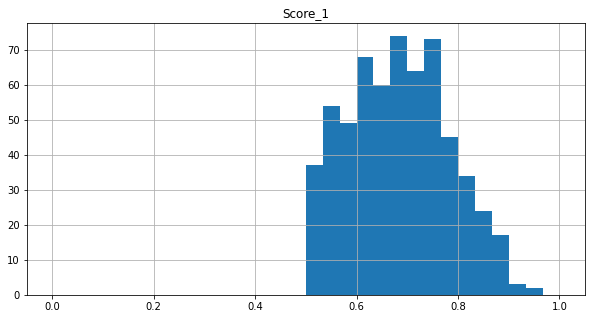

In [22]:
new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

### Let's plot the feature importances to see what features in the model are most predictive:

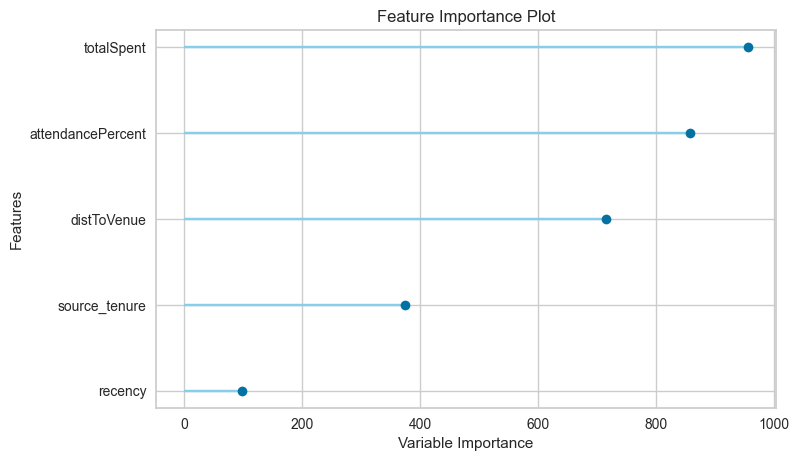

In [23]:
plot_model(best_model, plot='feature')

### Using a confusion matrix can also help us understand where the model is predicting correctly and where it's missing:

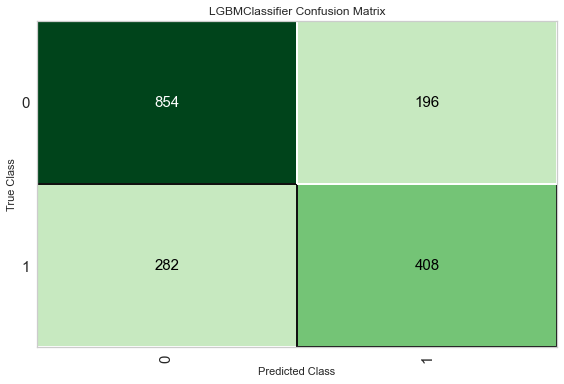

In [24]:
plot_model(best_model, plot='confusion_matrix')

### Let's also visualize the AUC (area under the curve) to get a sense of how our model is performing:

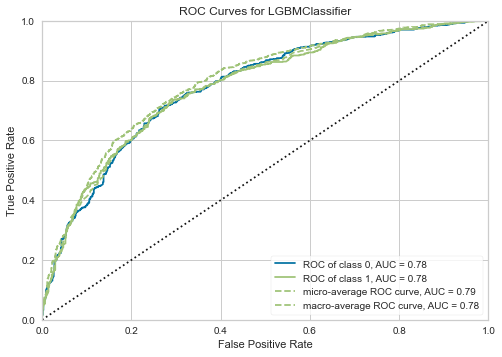

In [25]:
plot_model(best_model, plot="auc")

## Observations

* The model predictions are ~ 75% accurate 

* The Full Season ticket buyers fall into a Normal Distribution, as is expected.

* distToVenue is the third most important feature, with a variable importance ~ 75%

* The model made 3x as many correct predictions vs. incorrect predictions

## Conclusions

The distToVenue feature did prove to be a useful feature for model predictions. The next experiment will focus on altering the distToVenue feature to understand the impact (or non-impact) on model performance (i.e. does adding distance to the feature improve accuracy or have little to no impact).